In [602]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

### titanic 데이터 전처리
- 결측치 처리 : KNN imputer 사용하는 방법

In [603]:
df = pd.read_csv('data/titanic.csv')
df.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,F,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,C,True


In [604]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    int64  
 1   pclass      891 non-null    int64  
 2   sex         891 non-null    object 
 3   age         723 non-null    float64
 4   sibsp       891 non-null    int64  
 5   parch       891 non-null    int64  
 6   fare        891 non-null    float64
 7   embarked    889 non-null    object 
 8   class       891 non-null    object 
 9   who         891 non-null    object 
 10  adult_male  891 non-null    bool   
 11  deck        891 non-null    object 
 12  alone       891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(5)
memory usage: 78.4+ KB


In [605]:
# 고유값들 확인
print(df['sex'].value_counts())
print(df['embarked'].value_counts())
print(df['class'].value_counts())
print(df['who'].value_counts())
print(df['deck'].value_counts())

sex
male      577
female    314
Name: count, dtype: int64
embarked
S    644
C    168
Q     77
Name: count, dtype: int64
class
Third     491
First     216
Second    184
Name: count, dtype: int64
who
man      537
woman    271
child     83
Name: count, dtype: int64
deck
C    164
B    155
D    142
A    126
E    115
F     97
G     92
Name: count, dtype: int64


In [606]:
# 결측치 확인
df.isnull().sum()

survived        0
pclass          0
sex             0
age           168
sibsp           0
parch           0
fare            0
embarked        2
class           0
who             0
adult_male      0
deck            0
alone           0
dtype: int64

In [607]:
df['survived'].value_counts(normalize=True)

survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

<Axes: ylabel='Frequency'>

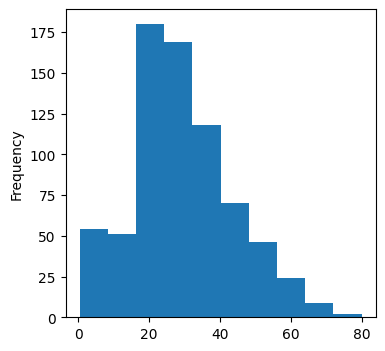

In [608]:
df['age'].plot(kind='hist', figsize=(4,4))

<Axes: xlabel='age'>

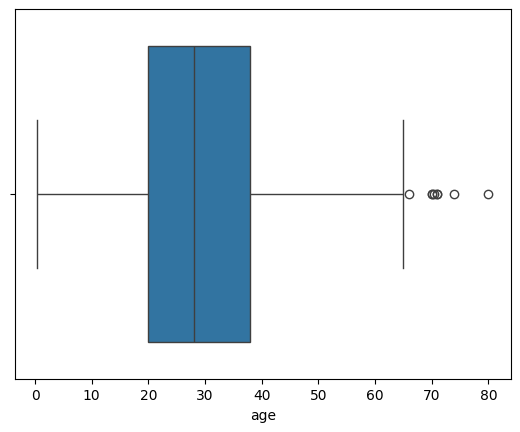

In [609]:
sns.boxplot(data=df, x='age')

<Axes: xlabel='sex'>

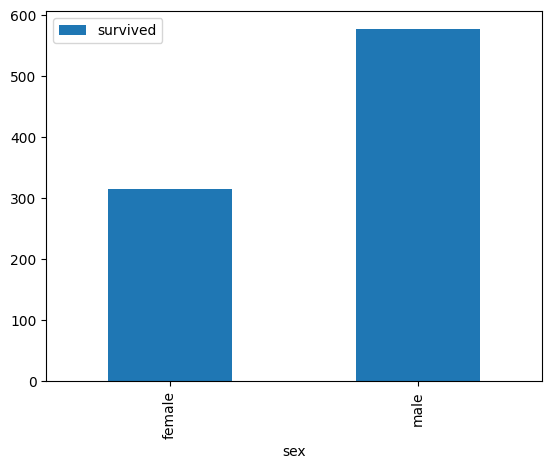

In [610]:
df.pivot_table(index='sex', values='survived', aggfunc='count').plot(kind='bar')

<Axes: xlabel='sex', ylabel='survived'>

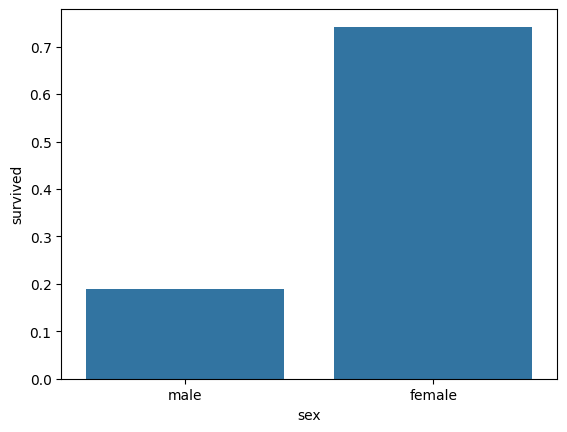

In [611]:
sns.barplot(df, x='sex', y='survived', estimator='mean', errorbar=None)

In [612]:
df.pivot_table(index='sex', columns='pclass', values='survived')

pclass,1,2,3
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


In [613]:
pd.crosstab(index=df['sex'], columns=df['pclass'], values=df['survived'], aggfunc='mean')

pclass,1,2,3
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


In [614]:
# 결측치 대치
# age 는 KNN imputer 로 대치(갯수가 많아서)
# embarked 는 결측치가 2개이므로 최빈값으로 대치
from sklearn.impute import KNNImputer
col_to_impute = ['age', 'sibsp', 'parch']   # 서로 관련이 있을법한 피처들을 포함한다
knn_imputer = KNNImputer(n_neighbors=10)
knn_result = knn_imputer.fit_transform(df[col_to_impute])
knn_result

array([[22.   ,  1.   ,  0.   ],
       [38.   ,  1.   ,  0.   ],
       [26.   ,  0.   ,  0.   ],
       ...,
       [20.792,  1.   ,  2.   ],
       [26.   ,  0.   ,  0.   ],
       [32.   ,  0.   ,  0.   ]], shape=(891, 3))

In [615]:
df['age'] = knn_result[:,0]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    int64  
 1   pclass      891 non-null    int64  
 2   sex         891 non-null    object 
 3   age         891 non-null    float64
 4   sibsp       891 non-null    int64  
 5   parch       891 non-null    int64  
 6   fare        891 non-null    float64
 7   embarked    889 non-null    object 
 8   class       891 non-null    object 
 9   who         891 non-null    object 
 10  adult_male  891 non-null    bool   
 11  deck        891 non-null    object 
 12  alone       891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(5)
memory usage: 78.4+ KB


In [616]:
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    int64  
 1   pclass      891 non-null    int64  
 2   sex         891 non-null    object 
 3   age         891 non-null    float64
 4   sibsp       891 non-null    int64  
 5   parch       891 non-null    int64  
 6   fare        891 non-null    float64
 7   embarked    891 non-null    object 
 8   class       891 non-null    object 
 9   who         891 non-null    object 
 10  adult_male  891 non-null    bool   
 11  deck        891 non-null    object 
 12  alone       891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(5)
memory usage: 78.4+ KB


In [617]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,F,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,C,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,A,True


survived    1.000000
pclass      0.338481
fare        0.257307
parch       0.081629
age         0.049676
Name: survived, dtype: float64


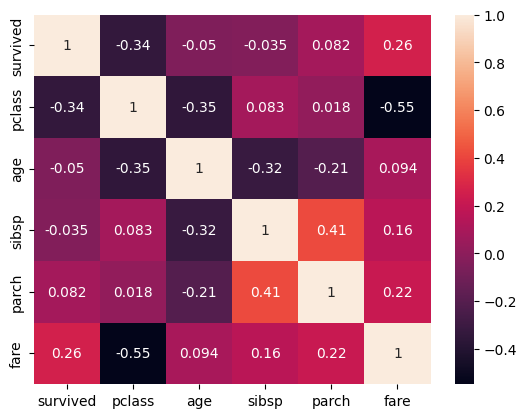

In [618]:
# 상관관계

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr_mat = df[num_cols].corr()
sns.heatmap(corr_mat, annot=True)
print(corr_mat['survived'].abs().nlargest(5))

### 결측치를 모두 처리한 뒤, 범주형 데이터 전처리
- sex, adult_male, alone : 값이 2종류 이고 순서가 없으므로 0,1 또는 False, True 로 mapping
- embarked, who, deck : 순서가 없고 값이 여러개 이므로 OneHot 인코딩
- class : 순서가 있고 값이 3종류 이므로 Ordinal 인코딩

In [619]:
df['sex'] = df['sex'].replace({'male':1, 'female':0})
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,alone
0,0,3,1,22.0,1,0,7.2500,S,Third,man,True,F,False
1,1,1,0,38.0,1,0,71.2833,C,First,woman,False,C,False
2,1,3,0,26.0,0,0,7.9250,S,Third,woman,False,C,True
3,1,1,0,35.0,1,0,53.1000,S,First,woman,False,C,False
4,0,3,1,35.0,0,0,8.0500,S,Third,man,True,A,True


#### 그냥 전체 get_dummies(df) 하면, 원래 컬럼은 사라진다! (매우 주의!)
#### df_temp = pd.get_dummies(df, dtype=int) 로 하면 0,1 로 인코딩된다. 그러나 DNN 모델은 bool 도 숫자값으로 인식하므로 굳이...

In [620]:
#### 연습
df_temp = pd.get_dummies(df, dtype=int)
df_temp.head()
# bool 타입은 변환하지 않으므로 별도 mapping 해줘야 한다.

,survived,pclass,sex,age,sibsp,parch,fare,adult_male,alone,embarked_C,embarked_Q,embarked_S,class_First,class_Second,class_Third,who_child,who_man,who_woman,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G
0,0,3,1,22.0,1,0,7.2500,True,False,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0
1,1,1,0,38.0,1,0,71.2833,False,False,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
2,1,3,0,26.0,0,0,7.9250,False,True,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0
3,1,1,0,35.0,1,0,53.1000,False,False,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0
4,0,3,1,35.0,0,0,8.0500,True,True,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0


In [621]:
#### 연습
# bool 타입을 labelencoding 할 수 있을까?
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
print(df_temp.adult_male.value_counts())
df_temp['adult_male_encoded'] = le.fit_transform(df_temp['adult_male'])
print(le.classes_)
print(df_temp.adult_male_encoded.value_counts())
# True = 1, False = 0 으로 인코딩 되었다.
print(df_temp.alone.value_counts())
df_temp['alone_encoded'] = le.transform(df_temp['alone'])
print(df_temp.alone_encoded.value_counts())

adult_male
True     537
False    354
Name: count, dtype: int64
[False  True]
adult_male_encoded
1    537
0    354
Name: count, dtype: int64
alone
True     537
False    354
Name: count, dtype: int64
alone_encoded
1    537
0    354
Name: count, dtype: int64


In [622]:
onehot_cols = ['embarked', 'who', 'deck']
# onehot_encoded = pd.get_dummies(df[onehot_cols])
onehot_encoded = pd.get_dummies(df[onehot_cols], dtype=int)  # 정수값 0,1로 인코딩 할 수도 있다
# 이렇게 하는 이유는 나중에 컬럼방향 concat 하기 때문.
# 일반적인 경우라면, pd.get_dummies(df, columns=onehot_cols, dtype=int) 로 한다.
onehot_encoded.head()
# drop_first 하면 안됨! 나중에 new data 와 column 이름과 순서 맞춰야 함!

,embarked_C,embarked_Q,embarked_S,who_child,who_man,who_woman,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G
0,0,0,1,0,1,0,0,0,0,0,0,1,0
1,1,0,0,0,0,1,0,0,1,0,0,0,0
2,0,0,1,0,0,1,0,0,1,0,0,0,0
3,0,0,1,0,0,1,0,0,1,0,0,0,0
4,0,0,1,0,1,0,1,0,0,0,0,0,0


In [ ]:
#### 연습
onehot_cols = ['adult_male', 'alone']
onehot_encoded2 = pd.get_dummies(df[onehot_cols], dtype=int)
onehot_encoded2.head()
# bool 타입은 변환 안됨. object, string, category 만 변환됨

,adult_male,alone
0,True,False
1,False,False
2,False,True
3,False,False
4,True,True


In [624]:
# bool 컬럼 인코딩
df['adult_male'] = df['adult_male'].astype(str).replace({'True':1, 'False':0})
df['alone'] = df['alone'].astype(str).replace({'True':1, 'False':0})

In [625]:
#### 연습

# 만약 한개의 컬럼만 인코딩 한다면,
# Series 를 입력했을때 (오답)
onehot_encoded_1 = pd.get_dummies(df['who'], dtype=int)
print(onehot_encoded_1.head())

# DataFrame 을 입력했을때 (이렇게 하는게 안전한 정답)
onehot_encoded_2 = pd.get_dummies(df[['who']], dtype=int) 
print(onehot_encoded_2.head())

# 만약 전체 df 를 인코딩하는데 target 컬럼을 지정한다면
onehot_encoded_3 = pd.get_dummies(df, columns=['who'], dtype=int)
print(onehot_encoded_3.head())

# 컬럼명이 다르므로 주의해야 한다! 이것이 틀리면 오답처리된다!
# 그리고 문제에서 데이터 전처리 mapping 을 (0, 1) 로 하고 있다면, dtype=int 를 추가해주는게 좋다!

   child  man  woman
0      0    1      0
1      0    0      1
2      0    0      1
3      0    0      1
4      0    1      0
   who_child  who_man  who_woman
0          0        1          0
1          0        0          1
2          0        0          1
3          0        0          1
4          0        1          0
   survived  pclass  sex   age  sibsp  parch     fare embarked  class  \
0         0       3    1  22.0      1      0   7.2500        S  Third   
1         1       1    0  38.0      1      0  71.2833        C  First   
2         1       3    0  26.0      0      0   7.9250        S  Third   
3         1       1    0  35.0      1      0  53.1000        S  First   
4         0       3    1  35.0      0      0   8.0500        S  Third   

   adult_male deck  alone  who_child  who_man  who_woman  
0           1    F      0          0        1          0  
1           0    C      0          0        0          1  
2           0    C      1          0        0          1  
3

In [626]:
df['class'].value_counts()
# First가 1순위, Third 가 3순위다.

class
Third     491
First     216
Second    184
Name: count, dtype: int64

In [627]:
# 여기서 OrdinalEncoder 사용법을 배운다.
from sklearn.preprocessing import OrdinalEncoder
class_order = ['First', 'Second', 'Third']  # 순서대로 0,1,2 로 인코딩된다.
oe = OrdinalEncoder(categories=[class_order])
class_encoded = pd.DataFrame(oe.fit_transform(df[['class']]), columns=['class_encoded'])
class_encoded
# 그러나 그냥 .replace({}) 로 매핑하는게 쉽겠다

,class_encoded
0,2.0
1,0.0
2,2.0
3,0.0
4,2.0
...,...
886,1.0
887,0.0
888,2.0
889,0.0


In [628]:
class_encoded.value_counts()
# First = 0.0 으로 인코딩 되었다(1순위)

class_encoded
2.0              491
0.0              216
1.0              184
Name: count, dtype: int64

In [629]:
df_final = pd.concat([df, onehot_encoded, class_encoded], axis=1)
df_final = df_final.drop(['embarked', 'who', 'deck', 'class'], axis=1)
df_final

,survived,pclass,sex,age,sibsp,parch,fare,adult_male,alone,embarked_C,embarked_Q,embarked_S,who_child,who_man,who_woman,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,class_encoded
0,0,3,1,22.000,1,0,7.2500,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,2.0
1,1,1,0,38.000,1,0,71.2833,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0.0
2,1,3,0,26.000,0,0,7.9250,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,2.0
3,1,1,0,35.000,1,0,53.1000,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0.0
4,0,3,1,35.000,0,0,8.0500,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.000,0,0,13.0000,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1.0
887,1,1,0,19.000,0,0,30.0000,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0.0
888,0,3,0,20.792,1,2,23.4500,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,2.0
889,1,1,1,26.000,0,0,30.0000,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0.0


In [630]:
# 데이터 분리
X = df_final.drop('survived', axis=1)
y = df_final['survived']
print(X.columns)

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'adult_male', 'alone',
       'embarked_C', 'embarked_Q', 'embarked_S', 'who_child', 'who_man',
       'who_woman', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F',
       'deck_G', 'class_encoded'],
      dtype='object')


In [631]:
# 출력층을 2개로 softmax 함수 사용
y = to_categorical(y, num_classes=2)
print(y)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [632]:
# dataset split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일링
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [633]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))   # keras recommend Input function
model.add(Dense(64, activation='selu'))
model.add(Dense(32, activation='selu'))
model.add(Dropout(rate=0.2))
model.add(Dense(16, activation='selu'))
model.add(Dropout(rate=0.2))
model.add(Dense(4, activation='selu'))
model.add(Dropout(rate=0.1))
model.add(Dense(2, activation='softmax'))

print(model.summary())

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_140 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,158 (16.24 KB)

 Trainable params: 4,158 (16.24 KB)

 Non-trainable params: 0 (0.00 B)

None


In [634]:
# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
'''
# loss = 'name' 으로 지정하는 기본값
# 회귀문제 : 'mean_squared_error'
# 2진 분류 : 'binary_crossentropy'
# 다중 클래스 분류
    - 'categorical_crossentropy' : 원핫인코딩 했을 경우 (pd.get_dummies)
    - 'sparse_categorical_crossentropy' : 원핫인코딩 안했을 경우 (LabelEncoder 정수 인코딩)

# metrics 기본 옵션 : 'accuracy', 'binary_accuracy', 'mse'
    다중 레이블 분류에서는 일반적인 accuracy가 성능을 과소평가 할 수 있음
        - binary_accuracy: 레이블별 정확도를 평가
        - precision, recall, f1_score: 클래스 불균형이나 특정 클래스(양성)에 초점을 맞출 때 유용
        - auc: 클래스 분리 능력을 평가
'''

"\n# loss = 'name' 으로 지정하는 기본값\n# 회귀문제 : 'mean_squared_error'\n# 2진 분류 : 'binary_crossentropy'\n# 다중 클래스 분류\n    - 'categorical_crossentropy' : 원핫인코딩 했을 경우 (pd.get_dummies)\n    - 'sparse_categorical_crossentropy' : 원핫인코딩 안했을 경우 (LabelEncoder 정수 인코딩)\n\n# metrics 기본 옵션 : 'accuracy', 'binary_accuracy', 'mse'\n    다중 레이블 분류에서는 일반적인 accuracy가 성능을 과소평가 할 수 있음\n        - binary_accuracy: 레이블별 정확도를 평가\n        - precision, recall, f1_score: 클래스 불균형이나 특정 클래스(양성)에 초점을 맞출 때 유용\n        - auc: 클래스 분리 능력을 평가\n"

In [635]:
# 모델 학습을 history 로 저장하려면,
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint    # point의 p 는 소문자임에 주의

es = EarlyStopping(monitor='val_loss', patience=9, verbose=1)
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train,
    y_train,    
    validation_data=(X_valid, y_valid),
    epochs=100,     # epochs 의 s 복수로 주의!
    batch_size=32,
    callbacks=[es, mc],
    verbose=1
)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6742 - loss: 0.9103 - val_accuracy: 0.7374 - val_loss: 0.4802
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7275 - loss: 0.7059 - val_accuracy: 0.7765 - val_loss: 0.5318
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7556 - loss: 0.6656 - val_accuracy: 0.7709 - val_loss: 0.4731
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7388 - loss: 0.6516 - val_accuracy: 0.7933 - val_loss: 0.4558
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7598 - loss: 0.6023 - val_accuracy: 0.8045 - val_loss: 0.4576
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7472 - loss: 0.6349 - val_accuracy: 0.7933 - val_loss: 0.4788
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7640 - loss: 0.5820 - val_accuracy: 0.7989 - val_loss: 0.4617
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7683 - loss: 0.5794 - val_accuracy: 0.8045 - v

In [636]:
print("딥러닝 모델 학습 완료")
train_result = model.evaluate(X_valid, y_valid)
# The returned list contains the loss value and metrics values
print(f"Test loss: {train_result[0]}")
print(f"Test accuracy: {train_result[1]}")

딥러닝 모델 학습 완료
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8156 - loss: 0.4297 
Test loss: 0.4297073185443878
Test accuracy: 0.8156424760818481


In [637]:
# 계산된 확률값은 2차원 리스트임(출력층=2 softmax)
y_prob = model.predict(X_valid)
print(y_prob[0:5])

# for roc-auc score (True 일 확률은 두번째 컬럼값이다!)
y_prob_score = y_prob[:,1]
print(y_prob_score[0:5])

# 이것을 0,1 1차원 리스트로 저장해야 한다.
y_pred = np.argmax(y_prob, axis=1)

#########################################################################################
# (중요) y_valid 도 to_categorical 되어 있으므로 점수 계산하려면 다시 1차원 리스트로 변환
#########################################################################################
y_valid = np.argmax(y_valid, axis=1)

print(y_pred[0:5])
print(y_valid[0:5])

# 만약 출력층=1 sigmoid binary_crossentrohy 라면,
# y_prob = model.predict(X_valid).ravel() --- 1차원 리스트로 변환
# y_pred = (y_prob > 0.5).astype(int) --- 0,1 값으로 변환
# 로 해야 metrics 스코어 들을 계산할 수 있다.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[[0.8890348  0.11096515]
 [0.88644314 0.11355694]
 [0.88332045 0.1166796 ]
 [0.04146919 0.9585308 ]
 [0.22472057 0.77527946]]
[0.11096515 0.11355694 0.1166796  0.9585308  0.77527946]
[0 0 0 1 1]
[1 0 0 1 1]


In [638]:
# 점수 출력
print("Classification Report", classification_report(y_valid, y_pred))
print("Accuracy:", accuracy_score(y_valid, y_pred))
print("Precision:", precision_score(y_valid, y_pred))
print("Recall:", recall_score(y_valid, y_pred))
print("F1 Score:", f1_score(y_valid, y_pred))

# roc auc score 출력 (y값, True 확률 입력)
print("ROC-AUC Score:", roc_auc_score(y_valid, y_prob_score))

Classification Report               precision    recall  f1-score   support

           0       0.83      0.86      0.85       105
           1       0.79      0.76      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.81      0.82      0.82       179

Accuracy: 0.8156424581005587
Precision: 0.7887323943661971
Recall: 0.7567567567567568
F1 Score: 0.7724137931034483
ROC-AUC Score: 0.8746460746460747


### 출력층=1 로 binary_crossentropy 적용한 모델도 해보자!

In [639]:
# 데이터 분리
X = df_final.drop('survived', axis=1)
y = df_final['survived']

# dataset split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일링
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation='selu'))
model.add(Dense(32, activation='selu'))
model.add(Dropout(rate=0.2))
model.add(Dense(16, activation='selu'))
model.add(Dropout(rate=0.2))
model.add(Dense(4, activation='selu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_145 (Dense)               │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,153 (16.22 KB)

 Trainable params: 4,153 (16.22 KB)

 Non-trainable params: 0 (0.00 B)

None


In [640]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', patience=9)
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train,
    y_train,    
    validation_data=(X_valid, y_valid),
    epochs=100,
    batch_size=32,
    callbacks=[es, mc],
    verbose=1
)

print("딥러닝 모델 학습 완료")
train_result = model.evaluate(X_valid, y_valid)
print(train_result)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6390 - loss: 0.6325 - val_accuracy: 0.7765 - val_loss: 0.4971
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7556 - loss: 0.5332 - val_accuracy: 0.7933 - val_loss: 0.4614
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7879 - loss: 0.4924 - val_accuracy: 0.8045 - val_loss: 0.4519
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8020 - loss: 0.4785 - val_accuracy: 0.8101 - val_loss: 0.4402
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7978 - loss: 0.4831 - val_accuracy: 0.8212 - val_loss: 0.4315
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8090 - loss: 0.4622 - val_accuracy: 0.8212 - val_loss: 0.4455
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8160 - loss: 0.4637 - val_accuracy: 0.8045 - val_loss: 0.4338
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7935 - loss: 0.4709 - val_accuracy: 0.8156 - v

In [641]:
# (중요) 출력층이 1이라도 확률값은 2차원 리스트임!
y_prob = model.predict(X_valid)
print(y_prob[0:5])

# 1차원 리스트로 변환
y_prob = y_prob.ravel()
print(y_prob[0:5])

# 0,1 결과값으로 변환 --> y_valid 와 비교!
y_pred = (y_prob > 0.5).astype(int)

print(y_valid[0:5]) # pandas series
print(y_pred[0:5])  # list

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[[0.09340756]
 [0.10497794]
 [0.08757238]
 [0.9426166 ]
 [0.5791476 ]]
[0.09340756 0.10497794 0.08757238 0.9426166  0.5791476 ]
709    1
439    0
840    0
720    1
39     1
Name: survived, dtype: int64
[0 0 0 1 1]


In [642]:
# 점수 출력
print("Classification Report", classification_report(y_valid, y_pred))
print("Accuracy:", accuracy_score(y_valid, y_pred))
print("Precision:", precision_score(y_valid, y_pred))
print("Recall:", recall_score(y_valid, y_pred))
print("F1 Score:", f1_score(y_valid, y_pred))

# roc auc score 출력 (y값, True 확률 입력)
print("ROC-AUC Score:", roc_auc_score(y_valid, y_prob))

Classification Report               precision    recall  f1-score   support

           0       0.82      0.87      0.84       105
           1       0.79      0.73      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Accuracy: 0.8100558659217877
Precision: 0.7941176470588235
Recall: 0.7297297297297297
F1 Score: 0.7605633802816901
ROC-AUC Score: 0.8719433719433719


#### new data 가 있으면, 값들이 0,1이면 원핫 인코딩 된것이고
#### 따라서, 답안도 pd.get_dummies(df, dtype=int) 로 서야 한다.
#### 만약 인코딩이 안되어 있다면(그럴 일은 없겠지만), 인코딩도 새로 하고
#### 컬럼명과 숫자도 맞춰야 한다.  컬럼명과 숫자는 X.columns 를 따라 가면 된다.